## Place Recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pygsp import graphs, filters, plotting, reduction
import pandas

%load_ext autoreload
%autoreload 2
%matplotlib inline
plotting.BACKEND = 'matplotlib'
plt.rcParams['figure.figsize'] = (10, 5)

In [2]:
dataset_path = '/home/berlukas/Documents/workspace/fgsp_ws/src/fgsp/data/gonzen_combined/'
opt_mission_01_file = dataset_path + 'mission_01.csv'
opt_mission_02_file = dataset_path + 'mission_02.csv'
opt_mission_03_file = dataset_path + 'mission_03.csv'
opt_mission_04_file = dataset_path + 'mission_04.csv'

labels = ['ts', 'vertex-id', 'mission_id', 'p_G_Ix', 'p_G_Iy', 'p_G_Iz', 'q_G_Iw', 'q_G_Ix', 'q_G_Iy', 'q_G_Iz', 'p_M_Ix', 'p_M_Iy', 'p_M_Iz', 'q_M_Iw', 'q_M_Ix', 'q_M_Iy', 'q_M_Iz', 'v_Mx', 'v_My', 'v_Mz', 'bgx', 'bgy', 'bgz', 'bax', 'bay', 'baz']
opt_mission_01_df = pandas.read_csv(opt_mission_01_file, names=labels, delimiter=',', header=None)
opt_mission_02_df = pandas.read_csv(opt_mission_02_file, names=labels, delimiter=',', header=None)
opt_mission_03_df = pandas.read_csv(opt_mission_03_file, names=labels, delimiter=',', header=None)
opt_mission_04_df = pandas.read_csv(opt_mission_04_file, names=labels, delimiter=',', header=None)

print(f'\nRead from mission 01: {opt_mission_01_df.size} (optimized)  entries.')
print(f'\nRead from mission 02: {opt_mission_02_df.size} (optimized)  entries.')
print(f'\nRead from mission 03: {opt_mission_03_df.size} (optimized)  entries.')
print(f'\nRead from mission 04: {opt_mission_04_df.size} (optimized)  entries.')


Read from mission 01: 64064 (optimized)  entries.

Read from mission 02: 58214 (optimized)  entries.

Read from mission 03: 28990 (optimized)  entries.

Read from mission 04: 51870 (optimized)  entries.


In [3]:
opt_mission_01_graph = opt_mission_01_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_02_graph = opt_mission_02_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_03_graph = opt_mission_03_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()
opt_mission_04_graph = opt_mission_04_df[['p_G_Ix', 'p_G_Iy', 'p_G_Iz']].to_numpy()

G_mission_01 = graphs.NNGraph(opt_mission_01_graph, use_flann=False, k=3)
G_mission_01.compute_fourier_basis()

G_mission_02 = graphs.NNGraph(opt_mission_02_graph, use_flann=False, k=3)
G_mission_02.compute_fourier_basis()

G_mission_03 = graphs.NNGraph(opt_mission_03_graph, use_flann=False, k=3)
G_mission_03.compute_fourier_basis()

G_mission_04 = graphs.NNGraph(opt_mission_04_graph, use_flann=False, k=3)
G_mission_04.compute_fourier_basis()

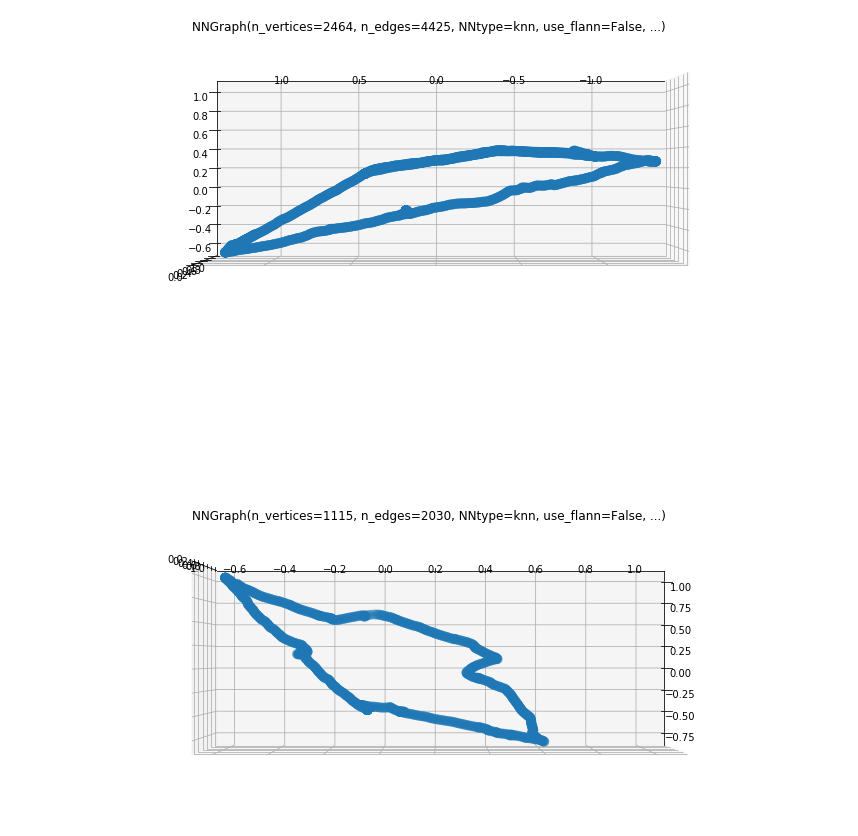

In [4]:
fig, axes = plt.subplots(2, 1, figsize=(15, 15), subplot_kw={'projection': '3d'})
fig.subplots_adjust(hspace=0.5)
G_mission_01.plot(ax=axes[0])
G_mission_03.plot(ax=axes[1])

axes[0].view_init(azim=90, elev=-90)
axes[1].view_init(azim=0, elev=-90)

In [50]:
# Compute the signals on the graph
opt_mission_01_origin = opt_mission_01_graph[0,:]
opt_mission_02_origin = opt_mission_02_graph[0,:]
opt_mission_03_origin = opt_mission_03_graph[0,:]
opt_mission_04_origin = opt_mission_04_graph[0,:]
opt_mission_01_pos_signal = (opt_mission_01_graph - opt_mission_01_origin).squeeze()
opt_mission_02_pos_signal = (opt_mission_02_graph - opt_mission_02_origin).squeeze()
opt_mission_03_pos_signal = (opt_mission_03_graph - opt_mission_03_origin).squeeze()
opt_mission_04_pos_signal = (opt_mission_04_graph - opt_mission_04_origin).squeeze()

x_mission_01 = np.linalg.norm(opt_mission_01_pos_signal, ord=2, axis=1)
x_mission_02 = np.linalg.norm(opt_mission_02_pos_signal, ord=2, axis=1)
x_mission_03 = np.linalg.norm(opt_mission_03_pos_signal, ord=2, axis=1)
x_mission_04 = np.linalg.norm(opt_mission_04_pos_signal, ord=2, axis=1)

In [5]:
def compute_coefficients(G, n_filter, signal):
    #g = filters.Meyer(G, Nf=n_filter)
    #g = filters.Heat(G, scale=15)
    g = filters.MexicanHat(G, Nf=n_filter)

    # Evalute filter bank on the frequencies (eigenvalues).
    f = g.evaluate(G.e)
    f = np.expand_dims(f.T, 1)

    W = np.zeros((G.N, n_filter))    
    for i in range(0, G.N):

        # We first compute the wavelets by multiplying the with a dirac centered at the individual nodes.
        x = np.zeros((G.N,1))
        x[i] = 1

        # Transform the dirac to spectral domain.
        s = G._check_signal(x)
        s = G.gft(s)

        if s.ndim == 1:
            s = np.expand_dims(s, -1)
        s = np.expand_dims(s, 1)
        s = np.matmul(s, f)

        # Transform back the wavelet to the vertex domain.
        s = G.igft(s).squeeze()        
        
        # Compute the features for all scales.
        for j in range(0, n_filter):
            W[i,j] = np.matmul(s[:,j].transpose(), signal)
    return W
        

# Compute the features.
n_filter = 3
W_mission_01 = compute_coefficients(G_mission_01, n_filter, x_mission_01)
#W_mission_02 = compute_coefficients(G_mission_02, n_filter, x_mission_02)
W_mission_03 = compute_coefficients(G_mission_03, n_filter, x_mission_03)
#W_mission_04 = compute_coefficients(G_mission_04, n_filter, x_mission_04)

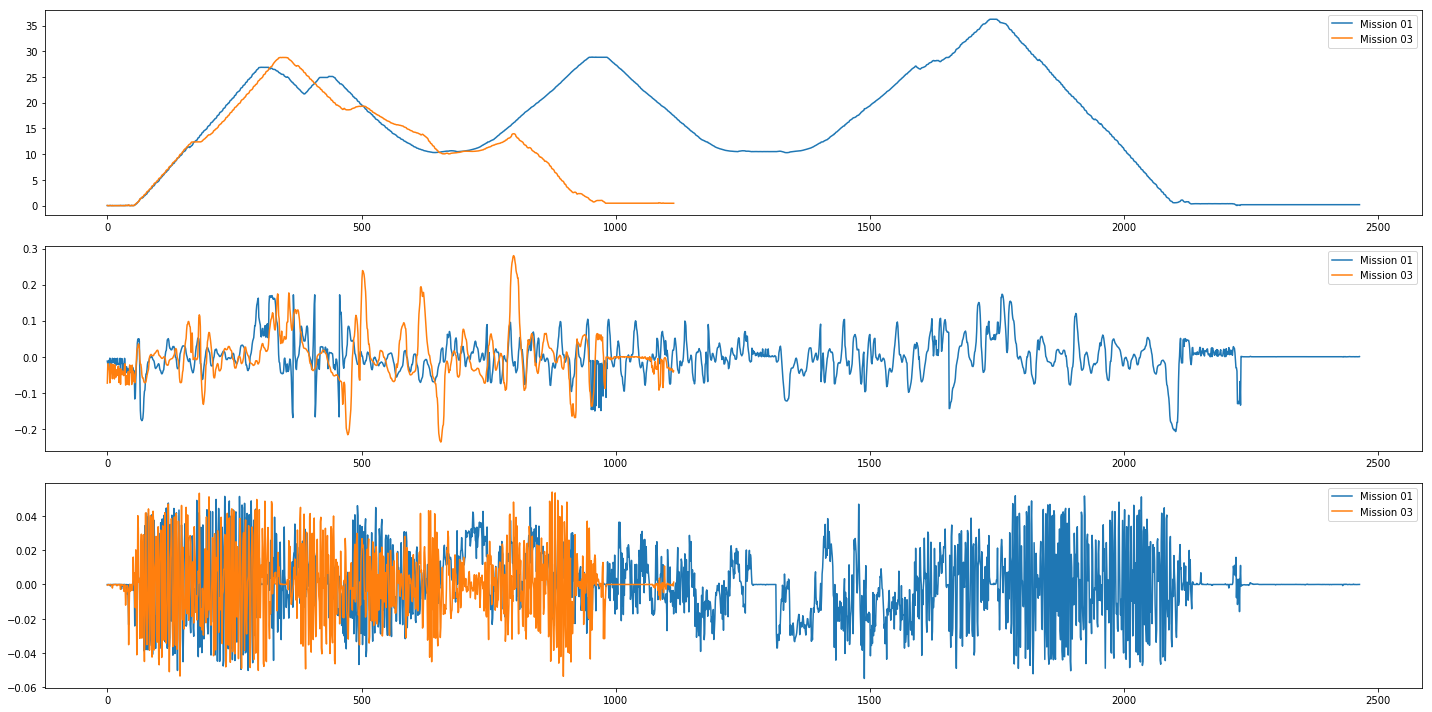

In [36]:
fig, axes = plt.subplots(n_filter, 1, figsize=(20, 10))
#fig.subplots_adjust(hspace=0.5)
axes = [axes] if n_filter == 1 else axes

for i in range(0, n_filter):
    axes[i].plot(W_mission_01[:,i], label='Mission 01')
    #axes[i].plot(W_mission_02[:,i], label='Mission 02')
    axes[i].plot(W_mission_03[:,i], label='Mission 03')
    #axes[i].plot(W_mission_04[:,i], label='Mission 04')
    axes[i].legend()
plt.tight_layout()

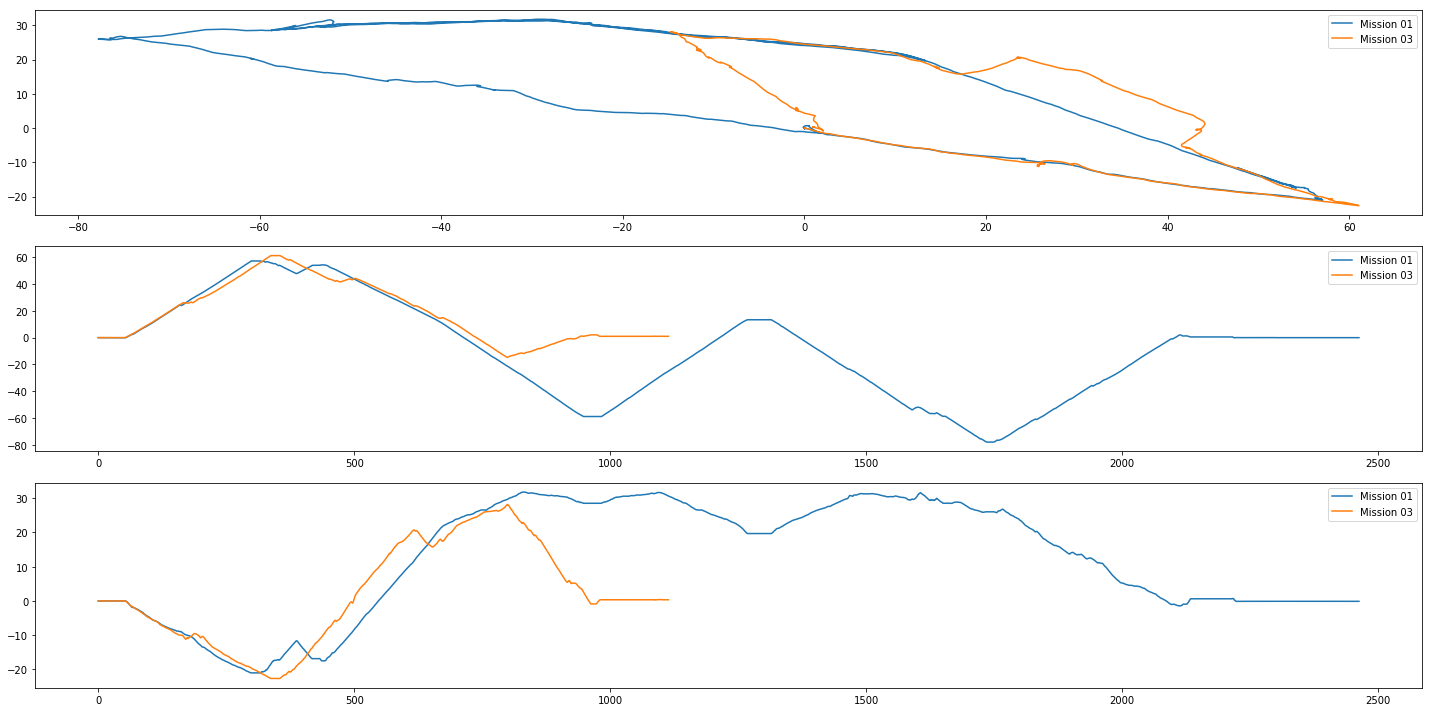

In [53]:
fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].plot(opt_mission_01_pos_signal[:,0], opt_mission_01_pos_signal[:,1], label='Mission 01')
axes[0].plot(opt_mission_03_pos_signal[:,0], opt_mission_03_pos_signal[:,1], label='Mission 03')
axes[0].legend()

axes[1].plot(opt_mission_01_pos_signal[:,0], label='Mission 01')
axes[1].plot(opt_mission_03_pos_signal[:,0], label='Mission 03')
axes[1].legend()

axes[2].plot(opt_mission_01_pos_signal[:,1], label='Mission 01')
axes[2].plot(opt_mission_03_pos_signal[:,1], label='Mission 03')
axes[2].legend()

plt.tight_layout()

In [45]:
def keyframe_signal(signal):
    pos_threshold = 1
    n_points = signal.shape[0]    
    prev_key_frame_pos = signal[0,:]
    mask = [True]*n_points
    for i in range(0, n_points):
        current_pos = signal[i,:]
        pos_diff = np.linalg.norm(prev_key_frame_pos - current_pos, ord=2)        
        if pos_diff > pos_threshold:
            mask[i] = False
            prev_key_frame_pos = current_pos
    signal[mask] = 0
    return signal, mask

mission_01_keyframed, mask_01 = keyframe_signal(opt_mission_01_pos_signal)
mission_02_keyframed, mask_02 = keyframe_signal(opt_mission_02_pos_signal)
mission_03_keyframed, mask_03 = keyframe_signal(opt_mission_03_pos_signal)
mission_04_keyframed, mask_04 = keyframe_signal(opt_mission_04_pos_signal)

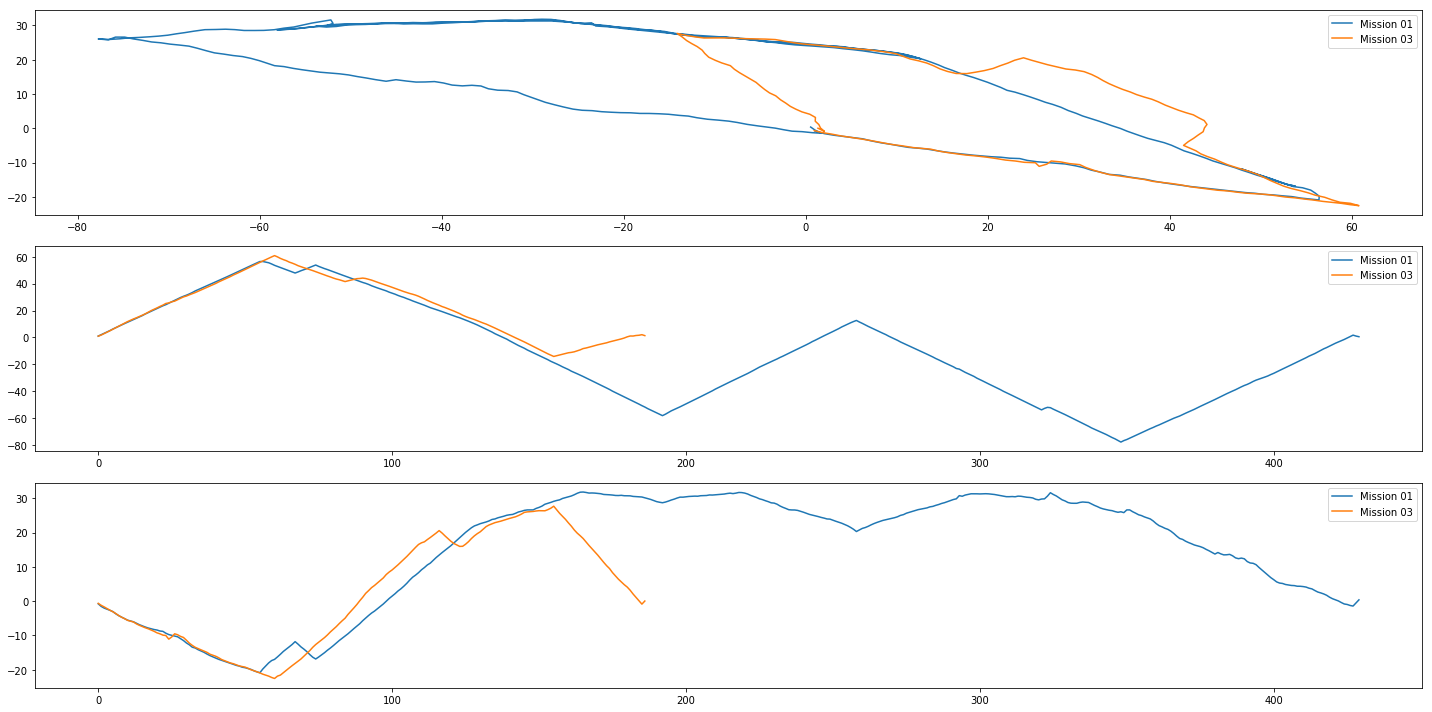

In [48]:
mission_01_traj = opt_mission_01_pos_signal[np.logical_not(mask_01)]
mission_03_traj = opt_mission_03_pos_signal[np.logical_not(mask_03)]

fig, axes = plt.subplots(3, 1, figsize=(20, 10))
axes[0].plot(mission_01_traj[:,0], mission_01_traj[:,1], label='Mission 01')
axes[0].plot(mission_03_traj[:,0], mission_03_traj[:,1], label='Mission 03')
axes[0].legend()

axes[1].plot(mission_01_traj[:,0], label='Mission 01')
axes[1].plot(mission_03_traj[:,0], label='Mission 03')
axes[1].legend()

axes[2].plot(mission_01_traj[:,1], label='Mission 01')
axes[2].plot(mission_03_traj[:,1], label='Mission 03')
axes[2].legend()

plt.tight_layout()

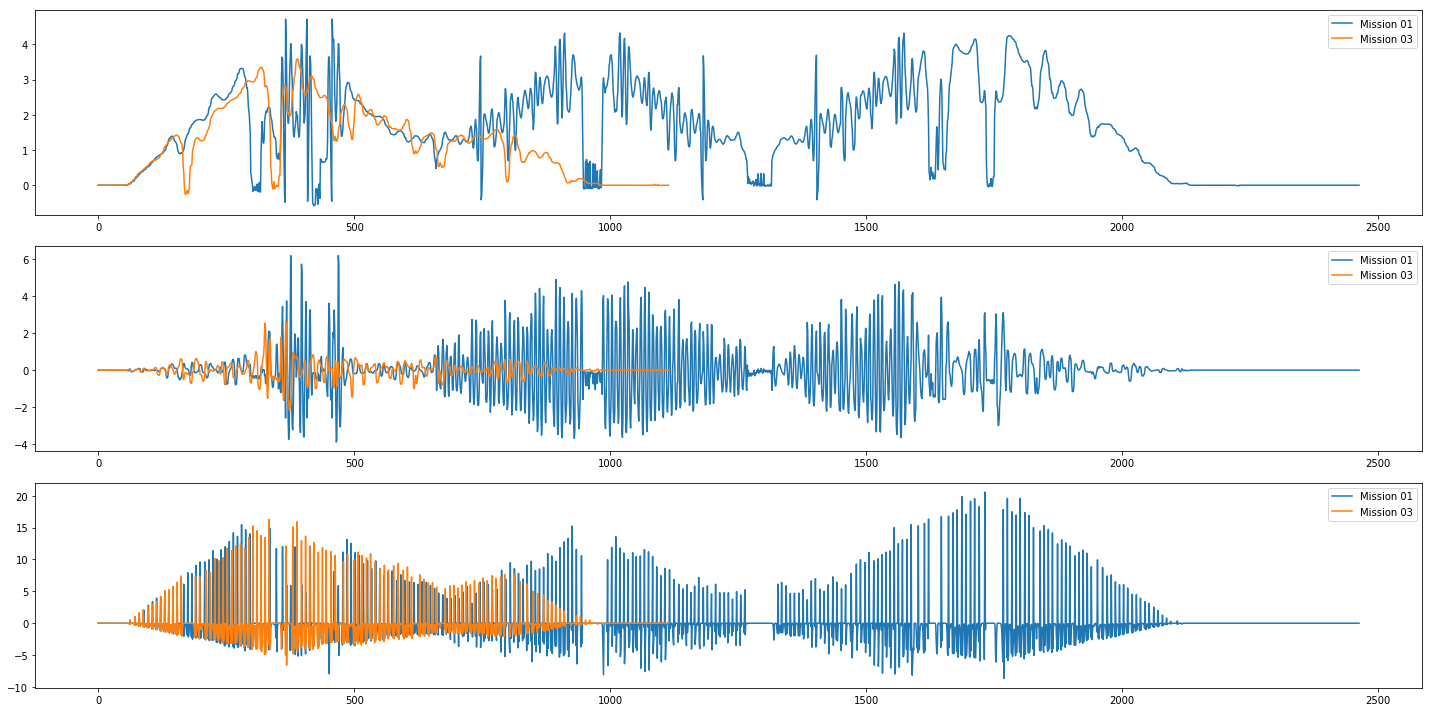

In [23]:
x_mission_01 = np.linalg.norm(mission_01_keyframed, ord=2, axis=1)
x_mission_02 = np.linalg.norm(mission_02_keyframed, ord=2, axis=1)
x_mission_03 = np.linalg.norm(mission_03_keyframed, ord=2, axis=1)
x_mission_04 = np.linalg.norm(mission_04_keyframed, ord=2, axis=1)

# Compute the features.
n_filter = 3
W_mission_01 = compute_coefficients(G_mission_01, n_filter, x_mission_01)
#W_mission_02 = compute_coefficients(G_mission_02, n_filter, x_mission_02)
W_mission_03 = compute_coefficients(G_mission_03, n_filter, x_mission_03)
#W_mission_04 = compute_coefficients(G_mission_04, n_filter, x_mission_04)

fig, axes = plt.subplots(n_filter, 1, figsize=(20, 10))
#fig.subplots_adjust(hspace=0.5)
axes = [axes] if n_filter == 1 else axes

for i in range(0, n_filter):
    axes[i].plot(W_mission_01[:,i], label='Mission 01')
    #axes[i].plot(W_mission_02[:,i], label='Mission 02')
    axes[i].plot(W_mission_03[:,i], label='Mission 03')
    #axes[i].plot(W_mission_04[:,i], label='Mission 04')
    axes[i].legend()
plt.tight_layout()